In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import arff
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from skmultiflow.trees import HoeffdingTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection import EDDM
from skmultiflow.drift_detection import ADWIN
from skmultiflow.drift_detection import HDDM_A
from skmultiflow.drift_detection import HDDM_W

from datetime import timedelta, date

from tqdm import tqdm
from itertools import groupby
from sklearn.decomposition import PCA

import random
import seaborn as sns

from collections import Counter
from operator import itemgetter
import operator

import itertools
from scipy import stats
from scipy.stats import mannwhitneyu
from math import log2
from sklearn.metrics.pairwise import manhattan_distances
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import kulsinski
from scipy.spatial.distance import cosine
from scipy.spatial.distance import sqeuclidean

from sklearn.metrics import accuracy_score

In [2]:
def drift_detect_function(drift_detector, y_true, y_pred, no_batches):
    batches_with_drift = []
    for i in range(0, no_batches):
        label_difference = abs(y_true[i] - y_pred[i])
        #print(label_difference)
        
        for j in tqdm(range(0, len(label_difference))):
            drift_detector.add_element(list(label_difference)[j])

            if(drift_detector.detected_change()):
                batches_with_drift.append(i)
    return batches_with_drift

In [3]:
# ADWIN has: 1 for correct prediction and 0 for incorrect prediction
def drift_detect_function_ADWIN(drift_detector, y_true, y_pred, no_batches):
    
    batches_with_drift = []
    for i in range(0, no_batches):
        label_difference = abs(y_true[i] - y_pred[i])
        label_difference_final = 1 - label_difference
    
        for j in tqdm(range(0, len(label_difference_final))):
            drift_detector.add_element(list(label_difference_final)[j])
            if(drift_detector.detected_change()):
                batches_with_drift.append(i)
    return batches_with_drift

In [4]:
def kl_divergence(p, q):
    return sum(p[0][i] * log2(p[0][i]/q[0][i]) for i in range(len(p[0])))

In [5]:
def bhattacharyya(p, q):
    return -np.log(sum(np.square(p[0][i]*1.0*q[0][i]) for i in range(len(p[0]))))

In [6]:
def bootstrapping(X_train, bootstrapping_samples, pca=None):
    # Extract distributions of 50 random training subsets
    distributions_bootstrapping = []
    for i in tqdm(range(0, bootstrapping_samples)):
        # generate random number between 0 and length_of_train-length_of_test in order to have a sample of size length_of_test
        rand = random.randint(0,len(X_train)-length_of_test)
        # extract the distribution from the training samples random number:random number + length_of_test by means of histogram
        if pca is not None:
            bootstrapping_input = pca.transform(X_train[rand:rand+length_of_test])
        else:
            bootstrapping_input = X_train[rand:rand+length_of_test]
        dist = sns.distplot(bootstrapping_input).get_lines()[0].get_data()[1]
        # store distribution
        distributions_bootstrapping.append(dist)
        plt.close()
    return distributions_bootstrapping

In [7]:
def kdqtrees_bootstrapping(distrib_X_train, distrib_X_test, distributions_bootstrapping, distance):
    
    # option to choose the similarity distance
    
    if(distance == 'kl_divergence'):
        similarity_metric = kl_divergence
    elif(distance == 'manhattan'):
        similarity_metric = manhattan_distances
    elif(distance == 'chebyshev'):
        similarity_metric = chebyshev
    elif(distance == 'kulsinski'):
        similarity_metric = kulsinski
    elif(distance == 'cosine'):
        similarity_metric = cosine
    elif(distance == 'squared_euclidean'):
        similarity_metric = sqeuclidean
    elif(distance == 'bhattacharyya'):
        similarity_metric = bhattacharyya
    
    # Bootstrapping technique to define critical region
    
    dist_bootstrapping = []
    
    # Calculate similarity distance between training set and each of the 50 training subsets
    for i in range(0, len(distributions_bootstrapping)):
        dist_bootstrapping.append(similarity_metric([distrib_X_train], [distributions_bootstrapping[i]]))
    
    
    # Define Critical Region
    critical_region = np.max(dist_bootstrapping)
    
    # Detect Drifts between train and test
    
    drift_batch = None
    
    # Calculate distance between train and test distributions
    
    similarity_metric_train_test = similarity_metric([distrib_X_train], [distrib_X_test])
    
    if(similarity_metric_train_test>critical_region):
        print(distance + " : Drift Detected" )
        return 1
    else:
        return 0

In [8]:
def compute_metric_false_positive(array_batches, drift_start):
        
    if(len(array_batches)>0): 
        
        if(len([x for x in array_batches if x<drift_start])>0):
            return(len([x for x in array_batches if x<drift_start])/drift_start)
        else:
            return 0
        
    else:
        return 'nothing_detected'

In [9]:
def ede_drift_detector(distrib_X_train, distrib_X_test, statistical_test):

    if(statistical_test == 'ks'):
        stat_test = stats.kstest
    elif(statistical_test == 'mw'):
        stat_test = stats.mannwhitneyu
    
    v, p = stat_test(distrib_X_train, distrib_X_test)
        
    
    if(p<=0.05):
        print("Reject Null Hypothesis according to KS statistical test")
        return 1
    else:
        return 0

In [10]:
def compute_metric_latency(array_batches, no_batches_with_drift, drift_start):
    
    if(len(array_batches)>0):  
        #print(np.array(array_pr)>=drift_type_start)
        #print(np.argwhere(np.array(array_pr)>=drift_type_start).size==0)
        
        if(np.argwhere(np.array(array_batches)>=drift_start).size==0):
            latency_score = 'nothing_detected' 
        else:
            batch_drift_detected = array_batches[np.argwhere(np.array(array_batches)>=drift_start)[0][0]]
            latency_score = (batch_drift_detected - drift_start)/no_batches_with_drift
        return latency_score
    else:
        return 'nothing_detected'

# Energy

In [11]:
data_energy = arff.loadarff('../elecNormNew.arff')
df_energy = pd.DataFrame(data_energy[0])


## Features Plot

Text(0.5, 1.0, 'vicdemand')

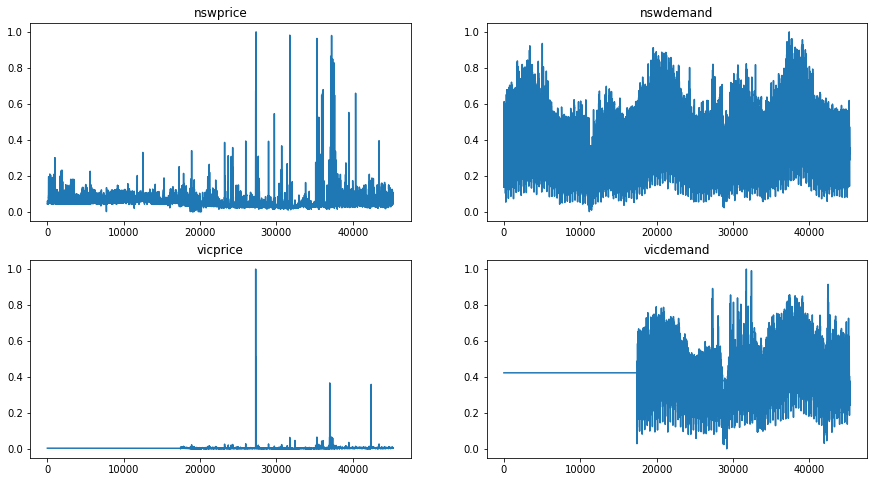

In [12]:
time = np.arange(len(df_energy))

fig, axs = plt.subplots(2,2, figsize=(15,8))


axs[0,0].plot(time, list(df_energy.nswprice))
axs[0,0].set_title('nswprice')

axs[0,1].plot(time, list(df_energy.nswdemand))
axs[0,1].set_title('nswdemand')

axs[1,0].plot(time, list(df_energy.vicprice))
axs[1,0].set_title('vicprice')

axs[1,1].plot(time, list(df_energy.vicdemand))
axs[1,1].set_title('vicdemand')

Text(0.5, 1.0, 'transfer')

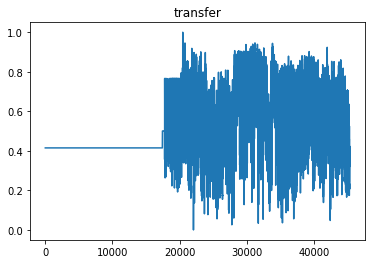

In [13]:
plt.plot(time, list(df_energy.transfer))
plt.title('transfer')

In [14]:
data_energy = arff.loadarff('../elecNormNew.arff')
df_energy = pd.DataFrame(data_energy[0])


# Adding the real date column to the dataset

In [15]:
day_list = list(df_energy.day)
day_list_str = []
for i in range(0, len(day_list)):
    day_list_str.append(str(day_list[i]))
day_list_str_non_duplicates = [key for key, _group in groupby(day_list_str)]


In [16]:
prev_day = day_list_str_non_duplicates[0]


In [17]:
for i in range(1, len(day_list_str_non_duplicates)):
    prev_day = day_list_str_non_duplicates[i-1]
    
    current_day = day_list_str_non_duplicates[i]
    
    if(prev_day == 'b\'7\''):
        expected_current_day = 'b\'1\''
    else:
        expected_current_day = 'b\'' + str(int(prev_day.split('\'')[1])+1)+ '\''
    if(current_day!= expected_current_day):
        print('fjidjsfio')

In [18]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

date_time_energy = []
start_date = date(1996, 5, 7)
end_date = date(1998, 12, 7)
for single_date in daterange(start_date, end_date):
    date_time_energy.append(single_date.strftime("%Y-%m-%d"))

In [19]:
date_energy_df = np.repeat(date_time_energy, 48)

In [20]:
df_energy['real_date'] = date_energy_df


In [21]:
# CONTINUE FROM HERE

### Label encoding

In [22]:
labelencoder = LabelEncoder()
df_energy['class'] = labelencoder.fit_transform(df_energy['class'])


training until the 15th of April.

In [23]:
training_samples_index = list(df_energy[df_energy.real_date == '1997-04-15'].index)[len(list(df_energy[df_energy.real_date == '1997-05-02'].index))-1]


## Split in Train and Test

In [24]:
train = df_energy[0:training_samples_index]


In [25]:
train_data = train.drop(['date', 'day', 'period', 'class', 'real_date'], axis = 1)
label_train_data = train['class']


In [28]:
np.count_nonzero(label_train_data)

7312

In [29]:
len(label_train_data)-np.count_nonzero(label_train_data)

9199

# Train Models

In [30]:
gnb = GaussianNB()
naive_bayes = gnb.fit(train_data, label_train_data)

ht = HoeffdingTreeClassifier()
hoeffding_tree = ht.fit(np.array(train_data), np.array(label_train_data))

adb = AdaBoostClassifier(n_estimators=100, random_state=0)
adaboost = adb.fit(train_data, label_train_data)

xgb = XGBClassifier()
xgboost = xgb.fit(train_data, label_train_data)

lgb = LGBMClassifier()
lightgbm = lgb.fit(train_data, label_train_data)

/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:17:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Test Models

Testing scenario: test model every week

In [31]:
test = df_energy[training_samples_index:]
test = test.reset_index(drop = True)


In [32]:
test_data = test.drop(['date', 'day', 'period', 'class', 'real_date'], axis = 1)
label_test_data = test['class']


In [33]:
dict_test = test.groupby(['real_date', 'day']).groups


In [34]:
dict_test_sorted = dict([(key , value) for (key, value) in sorted(dict_test.items())])


In [35]:
week_values = list(dict_test_sorted.values())


In [36]:
indexes_testing_batches = []
for i in range(0, len(week_values), 7):
    index = []
    for j in range(0, len(week_values[i:i+7])):
        for k in range(0, len(week_values[i:i+7][j])):
            index.append(week_values[i:i+7][j][k])
    indexes_testing_batches.append(index)
# len(indexes_testing_batches)

In [37]:
y_pred_naivebayes = []
y_pred_hoftree = []
y_pred_adaboost = []
y_pred_xgboost = []
y_pred_lightgbm = []

df_test_labels_total = []


for i in tqdm(range(0, len(indexes_testing_batches))):
    testing_batch = pd.DataFrame()
    label_batch = []
    
    index_current_testing_batch = indexes_testing_batches[i]
    
    testing_batch = test_data[(index_current_testing_batch[0]):(index_current_testing_batch[-1]+1)]
    label_batch = label_test_data[(index_current_testing_batch[0]):(index_current_testing_batch[-1]+1)]

    df_test_labels_total.append(list(label_batch))
    
    # Naive Bayes
    y_pred_nb = naive_bayes.predict(testing_batch)
    y_pred_naivebayes.append(y_pred_nb)
    
    
    # Hoeffding Trees
    y_pred_ht = hoeffding_tree.predict(np.array(testing_batch))
    y_pred_hoftree.append(y_pred_ht)
    
    # Adaboost
    y_pred_adb = adaboost.predict(testing_batch)
    y_pred_adaboost.append(y_pred_adb)
    
    # XGBoost
    y_pred_xgb = xgboost.predict(testing_batch)
    y_pred_xgboost.append(y_pred_xgb)
    
    # LightGBM
    y_pred_lgbm = lightgbm.predict(testing_batch)
    y_pred_lightgbm.append(y_pred_lgbm)

100%|██████████| 86/86 [00:03<00:00, 24.50it/s]


In [38]:
y_pred_dict = {'NaiveBayes': y_pred_naivebayes, 
                   'HoeffdingTree' : y_pred_hoftree, 
                   'Adaboost' : y_pred_adaboost,
                   'XGBoost' : y_pred_xgboost,
                   'LightGBM' : y_pred_lightgbm}

In [46]:
len(y_pred_dict['NaiveBayes'])

86

In [56]:
np.count_nonzero(y_pred_dict['NaiveBayes'][2])

51

In [57]:
len(y_pred_dict['NaiveBayes'][2])-np.count_nonzero(y_pred_dict['NaiveBayes'][2])

285

In [58]:
y_pred_dict['NaiveBayes'][2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [63]:
ratios = []
for i in range(0, len(y_pred_dict['NaiveBayes'])):
    if(np.count_nonzero(y_pred_dict['NaiveBayes'][i])!=0):
        print(i)
        ratios.append((len(y_pred_dict['NaiveBayes'][i])-np.count_nonzero(y_pred_dict['NaiveBayes'][i]))/np.count_nonzero(y_pred_dict['NaiveBayes'][i]))
ratios

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
49
50
51
53
55
56
57
58
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


[14.210526315789474,
 17.666666666666668,
 5.588235294117647,
 1.2105263157894737,
 2.9069767441860463,
 7.0,
 3.869565217391304,
 4.419354838709677,
 5.222222222222222,
 3.9411764705882355,
 5.0,
 55.0,
 66.2,
 11.444444444444445,
 9.838709677419354,
 15.0,
 7.0,
 10.2,
 335.0,
 12.44,
 13.608695652173912,
 8.333333333333334,
 5.222222222222222,
 36.333333333333336,
 5.109090909090909,
 10.2,
 14.272727272727273,
 13.608695652173912,
 10.586206896551724,
 47.0,
 3.0,
 23.0,
 167.0,
 335.0,
 66.2,
 27.0,
 66.2,
 55.0,
 335.0,
 83.0,
 24.846153846153847,
 41.0,
 111.0,
 12.44,
 335.0,
 83.0,
 335.0,
 23.0,
 83.0,
 9.181818181818182,
 4.793103448275862,
 4.333333333333333,
 2.652173913043478,
 7.615384615384615,
 1.8,
 1.4705882352941178,
 1.3661971830985915,
 1.688,
 0.9881656804733728,
 1.0740740740740742,
 0.37142857142857144,
 0.5849056603773585,
 0.5700934579439252,
 1.1,
 0.6551724137931034,
 0.9881656804733728,
 1.048780487804878,
 0.7777777777777778,
 2.169811320754717,
 2.326732

In [64]:
ratios

[14.210526315789474,
 17.666666666666668,
 5.588235294117647,
 1.2105263157894737,
 2.9069767441860463,
 7.0,
 3.869565217391304,
 4.419354838709677,
 5.222222222222222,
 3.9411764705882355,
 5.0,
 55.0,
 66.2,
 11.444444444444445,
 9.838709677419354,
 15.0,
 7.0,
 10.2,
 335.0,
 12.44,
 13.608695652173912,
 8.333333333333334,
 5.222222222222222,
 36.333333333333336,
 5.109090909090909,
 10.2,
 14.272727272727273,
 13.608695652173912,
 10.586206896551724,
 47.0,
 3.0,
 23.0,
 167.0,
 335.0,
 66.2,
 27.0,
 66.2,
 55.0,
 335.0,
 83.0,
 24.846153846153847,
 41.0,
 111.0,
 12.44,
 335.0,
 83.0,
 335.0,
 23.0,
 83.0,
 9.181818181818182,
 4.793103448275862,
 4.333333333333333,
 2.652173913043478,
 7.615384615384615,
 1.8,
 1.4705882352941178,
 1.3661971830985915,
 1.688,
 0.9881656804733728,
 1.0740740740740742,
 0.37142857142857144,
 0.5849056603773585,
 0.5700934579439252,
 1.1,
 0.6551724137931034,
 0.9881656804733728,
 1.048780487804878,
 0.7777777777777778,
 2.169811320754717,
 2.326732

# Detect Drift

In [35]:
no_batches = len(indexes_testing_batches)


In [36]:
classifier_list = []
detector_list = []
batches_detected = []

for i in tqdm(range(0, len(list(y_pred_dict.keys())))):
    classifier_list.append(list(y_pred_dict.keys())[i])
    
    detector_list.append('DDM')
    batches_detected.append(drift_detect_function(DDM(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))
    
    detector_list.append('EDDM')
    batches_detected.append(drift_detect_function(EDDM(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))
    
    detector_list.append('ADWIN')
    batches_detected.append(drift_detect_function(ADWIN(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))
    
    detector_list.append('HDDM_A')
    batches_detected.append(drift_detect_function(HDDM_A(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))
    
    detector_list.append('HDDM_W')
    batches_detected.append(drift_detect_function(HDDM_W(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))

batches_detected_clean = []
for i in range(0, len(batches_detected)):
    batches_detected_clean.append(list(dict.fromkeys(batches_detected[i])))

classifier_list = list(itertools.chain.from_iterable(itertools.repeat(x, 5) for x in classifier_list))



100%|██████████| 289/289 [00:00<00:00, 38662.73it/s]

100%|██████████| 336/336 [00:00<00:00, 36988.17it/s]

100%|██████████| 336/336 [00:00<00:00, 38051.79it/s]

100%|██████████| 336/336 [00:00<00:00, 38142.42it/s]

100%|██████████| 336/336 [00:00<00:00, 38781.64it/s]

100%|██████████| 336/336 [00:00<00:00, 39047.05it/s]

100%|██████████| 336/336 [00:00<00:00, 38682.65it/s]

100%|██████████| 336/336 [00:00<00:00, 36628.62it/s]

100%|██████████| 336/336 [00:00<00:00, 38853.28it/s]

100%|██████████| 336/336 [00:00<00:00, 33687.58it/s]

100%|██████████| 336/336 [00:00<00:00, 38069.27it/s]

100%|██████████| 336/336 [00:00<00:00, 34411.44it/s]

100%|██████████| 336/336 [00:00<00:00, 36963.91it/s]

100%|██████████| 336/336 [00:00<00:00, 32660.17it/s]

100%|██████████| 336/336 [00:00<00:00, 33450.10it/s]

100%|██████████| 336/336 [00:00<00:00, 34107.46it/s]

100%|██████████| 336/336 [00:00<00:00, 35686.26it/s]

100%|██████████| 336/336 [00:00<00:00, 36963.91it/s]

100%|██████████| 336/336 [00

100%|██████████| 336/336 [00:00<00:00, 41853.35it/s]

100%|██████████| 336/336 [00:00<00:00, 42943.78it/s]

100%|██████████| 336/336 [00:00<00:00, 42375.62it/s]

100%|██████████| 336/336 [00:00<00:00, 41465.45it/s]

100%|██████████| 336/336 [00:00<00:00, 42265.06it/s]

100%|██████████| 336/336 [00:00<00:00, 43027.70it/s]

100%|██████████| 336/336 [00:00<00:00, 42132.38it/s]

100%|██████████| 336/336 [00:00<00:00, 42025.59it/s]

100%|██████████| 336/336 [00:00<00:00, 47918.60it/s]

100%|██████████| 336/336 [00:00<00:00, 47479.49it/s]

100%|██████████| 336/336 [00:00<00:00, 47756.22it/s]

100%|██████████| 336/336 [00:00<00:00, 50382.03it/s]

100%|██████████| 336/336 [00:00<00:00, 48499.08it/s]

100%|██████████| 336/336 [00:00<00:00, 43050.04it/s]

100%|██████████| 336/336 [00:00<00:00, 48567.60it/s]

100%|██████████| 336/336 [00:00<00:00, 43927.63it/s]

100%|██████████| 336/336 [00:00<00:00, 38273.98it/s]

100%|██████████| 336/336 [00:00<00:00, 41718.31it/s]

100%|██████████| 336/336 [00

100%|██████████| 336/336 [00:00<00:00, 14320.41it/s]

100%|██████████| 336/336 [00:00<00:00, 12134.79it/s]

100%|██████████| 336/336 [00:00<00:00, 13672.43it/s]

100%|██████████| 336/336 [00:00<00:00, 12033.15it/s]

100%|██████████| 336/336 [00:00<00:00, 12455.58it/s]

100%|██████████| 336/336 [00:00<00:00, 12932.08it/s]

100%|██████████| 336/336 [00:00<00:00, 12737.35it/s]

100%|██████████| 336/336 [00:00<00:00, 12266.82it/s]

100%|██████████| 336/336 [00:00<00:00, 12905.20it/s]

100%|██████████| 336/336 [00:00<00:00, 12097.19it/s]

100%|██████████| 336/336 [00:00<00:00, 13904.59it/s]

100%|██████████| 336/336 [00:00<00:00, 13540.28it/s]

100%|██████████| 336/336 [00:00<00:00, 13861.92it/s]

100%|██████████| 336/336 [00:00<00:00, 13008.23it/s]

100%|██████████| 336/336 [00:00<00:00, 14345.49it/s]

100%|██████████| 336/336 [00:00<00:00, 13729.31it/s]

100%|██████████| 336/336 [00:00<00:00, 13834.03it/s]

100%|██████████| 336/336 [00:00<00:00, 12248.80it/s]

100%|██████████| 336/336 [00

100%|██████████| 336/336 [00:00<00:00, 37583.97it/s]

100%|██████████| 336/336 [00:00<00:00, 39814.84it/s]

100%|██████████| 336/336 [00:00<00:00, 38474.60it/s]

100%|██████████| 336/336 [00:00<00:00, 43597.41it/s]

100%|██████████| 336/336 [00:00<00:00, 38781.64it/s]

100%|██████████| 336/336 [00:00<00:00, 35502.86it/s]

100%|██████████| 336/336 [00:00<00:00, 34843.65it/s]

100%|██████████| 336/336 [00:00<00:00, 40307.93it/s]

100%|██████████| 336/336 [00:00<00:00, 44099.45it/s]

100%|██████████| 336/336 [00:00<00:00, 42705.64it/s]

100%|██████████| 336/336 [00:00<00:00, 36612.44it/s]

100%|██████████| 336/336 [00:00<00:00, 36502.44it/s]

100%|██████████| 336/336 [00:00<00:00, 36645.76it/s]

100%|██████████| 336/336 [00:00<00:00, 35435.91it/s]

100%|██████████| 336/336 [00:00<00:00, 36604.83it/s]

100%|██████████| 336/336 [00:00<00:00, 35502.86it/s]

100%|██████████| 336/336 [00:00<00:00, 36948.41it/s]

100%|██████████| 336/336 [00:00<00:00, 37163.74it/s]

100%|██████████| 336/336 [00

100%|██████████| 336/336 [00:00<00:00, 28729.87it/s]

100%|██████████| 336/336 [00:00<00:00, 24742.55it/s]

100%|██████████| 336/336 [00:00<00:00, 23300.92it/s]

100%|██████████| 336/336 [00:00<00:00, 21505.31it/s]

100%|██████████| 336/336 [00:00<00:00, 22506.45it/s]

100%|██████████| 336/336 [00:00<00:00, 18783.47it/s]

100%|██████████| 336/336 [00:00<00:00, 26760.46it/s]

100%|██████████| 336/336 [00:00<00:00, 19743.71it/s]

100%|██████████| 336/336 [00:00<00:00, 20934.45it/s]

100%|██████████| 336/336 [00:00<00:00, 21976.83it/s]

100%|██████████| 336/336 [00:00<00:00, 27428.16it/s]

100%|██████████| 336/336 [00:00<00:00, 26925.60it/s]

100%|██████████| 336/336 [00:00<00:00, 25866.06it/s]

100%|██████████| 336/336 [00:00<00:00, 27013.86it/s]

100%|██████████| 336/336 [00:00<00:00, 26803.21it/s]

100%|██████████| 336/336 [00:00<00:00, 27317.04it/s]

100%|██████████| 336/336 [00:00<00:00, 26612.40it/s]

100%|██████████| 336/336 [00:00<00:00, 27160.68it/s]

100%|██████████| 336/336 [00

100%|██████████| 336/336 [00:00<00:00, 12993.00it/s]

100%|██████████| 336/336 [00:00<00:00, 12268.96it/s]

100%|██████████| 336/336 [00:00<00:00, 12805.41it/s]

100%|██████████| 336/336 [00:00<00:00, 12295.08it/s]

100%|██████████| 336/336 [00:00<00:00, 12844.50it/s]

100%|██████████| 336/336 [00:00<00:00, 12549.86it/s]

100%|██████████| 336/336 [00:00<00:00, 12938.37it/s]

100%|██████████| 336/336 [00:00<00:00, 12644.89it/s]

100%|██████████| 336/336 [00:00<00:00, 12905.20it/s]

100%|██████████| 336/336 [00:00<00:00, 12560.71it/s]

100%|██████████| 336/336 [00:00<00:00, 13170.28it/s]

100%|██████████| 336/336 [00:00<00:00, 12810.18it/s]

100%|██████████| 336/336 [00:00<00:00, 12602.15it/s]

100%|██████████| 336/336 [00:00<00:00, 13275.86it/s]

100%|██████████| 336/336 [00:00<00:00, 14840.37it/s]

100%|██████████| 336/336 [00:00<00:00, 14526.48it/s]

100%|██████████| 336/336 [00:00<00:00, 13806.11it/s]

100%|██████████| 336/336 [00:00<00:00, 13019.65it/s]

100%|██████████| 336/336 [00

100%|██████████| 336/336 [00:00<00:00, 60174.47it/s]

100%|██████████| 336/336 [00:00<00:00, 62154.28it/s]

100%|██████████| 336/336 [00:00<00:00, 56337.64it/s]

100%|██████████| 336/336 [00:00<00:00, 58926.50it/s]

100%|██████████| 336/336 [00:00<00:00, 55145.02it/s]

100%|██████████| 336/336 [00:00<00:00, 47511.50it/s]

100%|██████████| 336/336 [00:00<00:00, 57150.99it/s]

100%|██████████| 336/336 [00:00<00:00, 46634.22it/s]

100%|██████████| 336/336 [00:00<00:00, 45808.10it/s]

100%|██████████| 336/336 [00:00<00:00, 45845.35it/s]

100%|██████████| 336/336 [00:00<00:00, 43237.59it/s]

100%|██████████| 336/336 [00:00<00:00, 47418.78it/s]

100%|██████████| 336/336 [00:00<00:00, 41984.27it/s]

100%|██████████| 336/336 [00:00<00:00, 45622.73it/s]

100%|██████████| 336/336 [00:00<00:00, 45670.04it/s]

100%|██████████| 336/336 [00:00<00:00, 45130.37it/s]

100%|██████████| 336/336 [00:00<00:00, 44008.56it/s]

100%|██████████| 336/336 [00:00<00:00, 44310.21it/s]

100%|██████████| 336/336 [00

100%|██████████| 336/336 [00:00<00:00, 28925.64it/s]

100%|██████████| 336/336 [00:00<00:00, 29554.70it/s]

100%|██████████| 336/336 [00:00<00:00, 29383.39it/s]

100%|██████████| 336/336 [00:00<00:00, 31881.42it/s]

100%|██████████| 336/336 [00:00<00:00, 28530.37it/s]

100%|██████████| 336/336 [00:00<00:00, 28260.90it/s]

100%|██████████| 336/336 [00:00<00:00, 28261.46it/s]

100%|██████████| 336/336 [00:00<00:00, 26778.77it/s]

100%|██████████| 336/336 [00:00<00:00, 26905.56it/s]

100%|██████████| 336/336 [00:00<00:00, 27832.25it/s]

100%|██████████| 336/336 [00:00<00:00, 25059.77it/s]

100%|██████████| 336/336 [00:00<00:00, 25237.03it/s]

100%|██████████| 336/336 [00:00<00:00, 26123.53it/s]

100%|██████████| 336/336 [00:00<00:00, 26757.92it/s]

100%|██████████| 336/336 [00:00<00:00, 26523.25it/s]

100%|██████████| 336/336 [00:00<00:00, 26082.92it/s]

100%|██████████| 336/336 [00:00<00:00, 26643.59it/s]

100%|██████████| 336/336 [00:00<00:00, 25741.33it/s]

100%|██████████| 336/336 [00

In [37]:
df_energy_eb_detectors = pd.DataFrame(list(zip(classifier_list, detector_list, batches_detected_clean)), columns =['Classifier', 'Detector', 'Batches_Detected'])
# df_energy_eb_detectors

# DDB Detectors

### Distribution of Reference Data

In [38]:
pca = PCA(n_components = 0.999)
pca.fit(train_data)

train_data_pca = pca.transform(train_data)

In [39]:
distribution_train = sns.distplot(train_data).get_lines()[0].get_data()[1]
plt.close()

distribution_train_pca = sns.distplot(train_data_pca).get_lines()[0].get_data()[1]
plt.close()

/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


### Distribution Bootstrapping

In [40]:
# length_of_test should be around 15000 (best compromise between all testing sets)
length_of_test = 15000
distributions_bootstrapping = bootstrapping(train_data, bootstrapping_samples=50)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  2%|▏         | 1/50 [00:00<00:14,  3.41it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  4%|▍         | 2/50 [00:00<00:13,  3.63it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/

 38%|███▊      | 19/50 [00:05<00:08,  3.79it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 40%|████      | 20/50 [00:05<00:07,  3.86it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 42%|████▏     | 21/50 [00:05<00:07,  3.89it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drif

 76%|███████▌  | 38/50 [00:09<00:02,  4.03it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 78%|███████▊  | 39/50 [00:10<00:02,  4.02it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 80%|████████  | 40/50 [00:10<00:02,  4.02it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drif

In [41]:
distributions_bootstrapping_pca = bootstrapping(train_data, bootstrapping_samples=50, pca=pca)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  2%|▏         | 1/50 [00:00<00:07,  7.00it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  4%|▍         | 2/50 [00:00<00:06,  6.98it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/

 38%|███▊      | 19/50 [00:02<00:04,  6.82it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 40%|████      | 20/50 [00:03<00:04,  6.94it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 42%|████▏     | 21/50 [00:03<00:04,  7.04it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drif

 76%|███████▌  | 38/50 [00:05<00:02,  5.65it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 78%|███████▊  | 39/50 [00:05<00:01,  6.05it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 80%|████████  | 40/50 [00:06<00:01,  6.34it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drif

In [42]:
distributions_test = []
distributions_test_pca = []

for i in tqdm(range(0, len(indexes_testing_batches))):
    
    index_current_testing_batch = indexes_testing_batches[i]
    
    testing_batch = test_data[(index_current_testing_batch[0]):(index_current_testing_batch[-1]+1)]

    dist_test = sns.distplot(testing_batch).get_lines()[0].get_data()[1]
    plt.close()
    
    dist_test_pca = sns.distplot(pca.transform(testing_batch)).get_lines()[0].get_data()[1]
    plt.close()
    
    distributions_test.append(dist_test)
    distributions_test_pca.append(dist_test_pca)

  0%|          | 0/86 [00:00<?, ?it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  1%|          | 1/86 [00:00<00:09,  8.53it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.

 12%|█▏        | 10/86 [00:01<00:09,  7.75it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 13%|█▎        | 11/86 [00:01<00:11,  6.72it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/dist

 23%|██▎       | 20/86 [00:02<00:08,  8.22it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 24%|██▍       | 21/86 [00:02<00:07,  8.32it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/dist

 35%|███▍      | 30/86 [00:03<00:07,  7.03it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 36%|███▌      | 31/86 [00:03<00:07,  7.47it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/dist

 47%|████▋     | 40/86 [00:04<00:05,  9.13it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 48%|████▊     | 41/86 [00:05<00:04,  9.22it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/dist

 58%|█████▊    | 50/86 [00:06<00:03,  9.01it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 59%|█████▉    | 51/86 [00:06<00:03,  9.04it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/dist

 70%|██████▉   | 60/86 [00:07<00:03,  8.26it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is

 81%|████████▏ | 70/86 [00:08<00:01,  9.57it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 83%|████████▎ | 71/86 [00:08<00:01,  9.49it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/dist

 93%|█████████▎| 80/86 [00:09<00:01,  5.62it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 94%|█████████▍| 81/86 [00:09<00:00,  6.25it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/dist

## EDE

In [43]:
detected_drifts_ks = []
detected_drifts_mw = []
for i in range(0, len(distributions_test)):
    if(ede_drift_detector(distribution_train, distributions_test[i], 'ks')==1):
        detected_drifts_ks.append(i)
    if(ede_drift_detector(distribution_train, distributions_test[i], 'mw')==1):
        detected_drifts_mw.append(i)

test = ['ks', 'mw']
drifts = [detected_drifts_ks, detected_drifts_mw]

Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistical test
Reject Null Hypothesis according to KS statistic

In [44]:
df_ede_bootstrapping = pd.DataFrame({'detector' : 'ede',
                                    'distance/test': test, 
                                    'Batches_Detected': drifts})
# df_ede_bootstrapping

## kdqTrees

In [45]:
kl_drift = []
mh_drift = []
cbs_drift = []
ksnk_drift = []
csn_drift = []
sqe_drift = []
bct_drift = []

for i in tqdm(range(0, len(distributions_test))):
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'kl_divergence') == 1):
        kl_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'manhattan') == 1):
        mh_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'chebyshev') == 1):
        cbs_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'kulsinski') == 1):
        ksnk_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'cosine') == 1):
        csn_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'squared_euclidean') == 1):
        sqe_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'bhattacharyya') == 1):
        bct_drift.append(i)
    #print(i)

distances = ['kl_div', 'manhattan', 'chebysev', 'kulsinski', 'cosine', 'sq_euclid', 'batthacrya']
drifts = [kl_drift, mh_drift, cbs_drift, ksnk_drift, csn_drift, sqe_drift, bct_drift]
df_kdqtrees_bootstrapping = pd.DataFrame({'detector' : 'kdqTrees',
                                        'distance/test': distances, 
                                        'Batches_Detected': drifts
                                })

  0%|          | 0/86 [00:00<?, ?it/s]

kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected


  3%|▎         | 3/86 [00:00<00:03, 22.78it/s]

chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


  7%|▋         | 6/86 [00:00<00:03, 21.70it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected

 10%|█         | 9/86 [00:00<00:03, 21.99it/s]


chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected

 14%|█▍        | 12/86 [00:00<00:03, 22.79it/s]


kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 17%|█▋        | 15/86 [00:00<00:03, 22.48it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 21%|██        | 18/86 [00:00<00:03, 22.62it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 24%|██▍       | 21/86 [00:00<00:02, 22.90it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected

 28%|██▊       | 24/86 [00:01<00:02, 21.44it/s]


squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 31%|███▏      | 27/86 [00:01<00:02, 21.75it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 35%|███▍      | 30/86 [00:01<00:02, 22.69it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 38%|███▊      | 33/86 [00:01<00:02, 22.01it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected


 42%|████▏     | 36/86 [00:01<00:02, 21.48it/s]

kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 45%|████▌     | 39/86 [00:01<00:02, 21.61it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 49%|████▉     | 42/86 [00:01<00:02, 21.48it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 52%|█████▏    | 45/86 [00:02<00:01, 22.45it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected

 56%|█████▌    | 48/86 [00:02<00:01, 23.17it/s]


kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected

 59%|█████▉    | 51/86 [00:02<00:01, 23.67it/s]


chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 63%|██████▎   | 54/86 [00:02<00:01, 23.55it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 66%|██████▋   | 57/86 [00:02<00:01, 22.96it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected

 70%|██████▉   | 60/86 [00:02<00:01, 23.74it/s]


kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected

 73%|███████▎  | 63/86 [00:02<00:00, 24.43it/s]


manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected

 77%|███████▋  | 66/86 [00:02<00:00, 24.90it/s]


squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected

 80%|████████  | 69/86 [00:03<00:00, 24.83it/s]


kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected

 84%|████████▎ | 72/86 [00:03<00:00, 24.73it/s]


chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected

 87%|████████▋ | 75/86 [00:03<00:00, 24.62it/s]


chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected

 91%|█████████ | 78/86 [00:03<00:00, 24.26it/s]


cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected

 94%|█████████▍| 81/86 [00:03<00:00, 24.80it/s]


squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected

100%|██████████| 86/86 [00:03<00:00, 23.31it/s]


chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected


In [46]:
# df_kdqtrees_bootstrapping

## PCA-kdq

In [47]:
kl_drift = []
mh_drift = []
cbs_drift = []
ksnk_drift = []
csn_drift = []
sqe_drift = []
bct_drift = []

for i in tqdm(range(0, len(distributions_test_pca))):

    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'kl_divergence') == 1):
        kl_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'manhattan') == 1):
        mh_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'chebyshev') == 1):
        cbs_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'kulsinski') == 1):
        ksnk_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'cosine') == 1):
        csn_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'squared_euclidean') == 1):
        sqe_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'bhattacharyya') == 1):
        bct_drift.append(i)
    #print(i)

distances = ['kl_div', 'manhattan', 'chebysev', 'kulsinski', 'cosine', 'sq_euclid', 'batthacrya']
drifts = [kl_drift, mh_drift, cbs_drift, ksnk_drift, csn_drift, sqe_drift, bct_drift]
df_pca_bootstrapping = pd.DataFrame({'detector' : 'pca',
                                     'distance/test': distances, 
                                     'Batches_Detected': drifts
                                })

merged_results = pd.concat([df_ede_bootstrapping, df_kdqtrees_bootstrapping, df_pca_bootstrapping])
merged_results = merged_results.reset_index(drop=True)




  0%|          | 0/86 [00:00<?, ?it/s]

kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


  3%|▎         | 3/86 [00:00<00:03, 23.88it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected

  7%|▋         | 6/86 [00:00<00:03, 24.50it/s]


cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected

 10%|█         | 9/86 [00:00<00:03, 24.26it/s]


manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 14%|█▍        | 12/86 [00:00<00:03, 24.48it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected

 17%|█▋        | 15/86 [00:00<00:02, 24.83it/s]


kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 21%|██        | 18/86 [00:00<00:02, 24.76it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected


 24%|██▍       | 21/86 [00:00<00:02, 23.93it/s]

kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 28%|██▊       | 24/86 [00:01<00:02, 23.21it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 31%|███▏      | 27/86 [00:01<00:02, 23.07it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 35%|███▍      | 30/86 [00:01<00:02, 23.13it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 38%|███▊      | 33/86 [00:01<00:02, 23.21it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 42%|████▏     | 36/86 [00:01<00:02, 23.64it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected

 45%|████▌     | 39/86 [00:01<00:01, 23.56it/s]


squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 49%|████▉     | 42/86 [00:01<00:01, 23.69it/s]

bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected

 52%|█████▏    | 45/86 [00:01<00:01, 24.21it/s]


manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected

 56%|█████▌    | 48/86 [00:02<00:01, 24.51it/s]


squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected


 59%|█████▉    | 51/86 [00:02<00:01, 24.85it/s]

kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 63%|██████▎   | 54/86 [00:02<00:01, 24.76it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected

 66%|██████▋   | 57/86 [00:02<00:01, 24.24it/s]


kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 70%|██████▉   | 60/86 [00:02<00:01, 23.93it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 73%|███████▎  | 63/86 [00:02<00:00, 24.25it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected

 77%|███████▋  | 66/86 [00:02<00:00, 24.44it/s]


kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected

 80%|████████  | 69/86 [00:02<00:00, 24.56it/s]


kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
manhattan : Drift Detected

 84%|████████▎ | 72/86 [00:02<00:00, 24.87it/s]


chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected

 87%|████████▋ | 75/86 [00:03<00:00, 24.88it/s]


cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected


 91%|█████████ | 78/86 [00:03<00:00, 24.77it/s]

kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected

 94%|█████████▍| 81/86 [00:03<00:00, 24.85it/s]


chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


 98%|█████████▊| 84/86 [00:03<00:00, 24.96it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected


100%|██████████| 86/86 [00:03<00:00, 24.27it/s]

bhattacharyya : Drift Detected
kl_divergence : Drift Detected
manhattan : Drift Detected
chebyshev : Drift Detected
kulsinski : Drift Detected
cosine : Drift Detected
squared_euclidean : Drift Detected
bhattacharyya : Drift Detected


In [48]:
# df_pca_bootstrapping

In [49]:
df_energy_ddb_detectors = pd.concat([df_ede_bootstrapping, df_kdqtrees_bootstrapping, df_pca_bootstrapping])
df_energy_ddb_detectors

,detector,distance/test,Batches_Detected
0,ede,ks,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,ede,mw,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
0,kdqTrees,kl_div,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,kdqTrees,manhattan,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,kdqTrees,chebysev,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,kdqTrees,kulsinski,[]
4,kdqTrees,cosine,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,kdqTrees,sq_euclid,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,kdqTrees,batthacrya,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
0,pca,kl_div,"[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 1..."


# Calculate metrics

In [50]:
no_batches_with_drift = 84 # there are 84 batches with drift because 3 feature start changing their behaviour after the 2nd of May 1997
drift_start = 2 # drift starts at batch 2, which is the week including the 2nd of May 1997 (30.04.1997-06.05.1997) 

In [51]:
latency_erb = []
fpr_erb = []

latency_ddb = []
fpr_ddb = []

for i in range(0, len(list(df_energy_eb_detectors.Batches_Detected))):
    latency_erb.append(compute_metric_latency(list(df_energy_eb_detectors.Batches_Detected)[i], no_batches_with_drift, drift_start))
    fpr_erb.append(compute_metric_false_positive(list(df_energy_eb_detectors.Batches_Detected)[i], drift_start))

for i in range(0, len(list(df_energy_ddb_detectors.Batches_Detected))):
    latency_ddb.append(compute_metric_latency(list(df_energy_ddb_detectors.Batches_Detected)[i], no_batches_with_drift, drift_start))
    fpr_ddb.append(compute_metric_false_positive(list(df_energy_ddb_detectors.Batches_Detected)[i], drift_start))

In [52]:
df_energy_eb_detectors['latency'] = latency_erb
df_energy_eb_detectors['fpr'] = fpr_erb
df_energy_eb_detectors

,Classifier,Detector,Batches_Detected,latency,fpr
0,NaiveBayes,DDM,"[2, 4, 7, 9, 10, 11, 12, 15, 18, 20, 21, 22, 2...",0.0,0.0
1,NaiveBayes,EDDM,"[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0.0,1.0
2,NaiveBayes,ADWIN,"[2, 3, 4, 8, 9, 11, 12, 14, 18, 21, 22, 23, 36...",0.0,0.0
3,NaiveBayes,HDDM_A,"[0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 1...",0.0,1.0
4,NaiveBayes,HDDM_W,"[0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16, 1...",0.0,1.0
5,HoeffdingTree,DDM,"[2, 5, 7, 8, 9, 10, 12, 15, 16, 17, 18, 20, 22...",0.0,0.0
6,HoeffdingTree,EDDM,"[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0.0,1.0
7,HoeffdingTree,ADWIN,"[2, 3, 4, 6, 8, 9, 14, 18, 19, 23, 25, 34, 48,...",0.0,0.0
8,HoeffdingTree,HDDM_A,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15...",0.0,1.0
9,HoeffdingTree,HDDM_W,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15,...",0.0,1.0


In [53]:
df_energy_ddb_detectors['latency'] = latency_ddb
df_energy_ddb_detectors['fpr'] = fpr_ddb
df_energy_ddb_detectors

,detector,distance/test,Batches_Detected,latency,fpr
0,ede,ks,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0,1.0
1,ede,mw,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0,1.0
0,kdqTrees,kl_div,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0,1.0
1,kdqTrees,manhattan,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0,1.0
2,kdqTrees,chebysev,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0,1.0
3,kdqTrees,kulsinski,[],nothing_detected,nothing_detected
4,kdqTrees,cosine,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0,1.0
5,kdqTrees,sq_euclid,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0,1.0
6,kdqTrees,batthacrya,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0,1.0
0,pca,kl_div,"[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0.0,1.0


In [57]:
list(y_pred_dict['NaiveBayes'][0])

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [75]:
accuracy_nb = []
for i in range(0, len(list(y_pred_dict['NaiveBayes']))):
    accuracy_nb.append(accuracy_score(list(df_test_labels_total[i]), list(y_pred_dict['NaiveBayes'][i])))

In [76]:
accuracy_nb

[0.7162629757785467,
 0.7291666666666666,
 0.75,
 0.9077380952380952,
 0.8303571428571429,
 0.7857142857142857,
 0.8630952380952381,
 0.6369047619047619,
 0.6755952380952381,
 0.6934523809523809,
 0.6041666666666666,
 0.6071428571428571,
 0.5773809523809523,
 0.7619047619047619,
 0.8809523809523809,
 0.7380952380952381,
 0.7916666666666666,
 0.6994047619047619,
 0.5148809523809523,
 0.5565476190476191,
 0.7470238095238095,
 0.7291666666666666,
 0.6309523809523809,
 0.7351190476190477,
 0.6488095238095238,
 0.7142857142857143,
 0.6369047619047619,
 0.5892857142857143,
 0.6904761904761905,
 0.6190476190476191,
 0.6696428571428571,
 0.43452380952380953,
 0.7261904761904762,
 0.6130952380952381,
 0.6964285714285714,
 0.6011904761904762,
 0.6458333333333334,
 0.6875,
 0.5565476190476191,
 0.6190476190476191,
 0.6666666666666666,
 0.5714285714285714,
 0.7410714285714286,
 0.5952380952380952,
 0.5773809523809523,
 0.6488095238095238,
 0.5982142857142857,
 0.46726190476190477,
 0.5178571428571

In [79]:
accuracy_ht = []
for i in range(0, len(list(y_pred_dict['HoeffdingTree']))):
    accuracy_nb.append(accuracy_score(list(df_test_labels_total[i]), list(y_pred_dict['HoeffdingTree'][i])))
accuracy_ht

[]

Count 0s and 1s.

In [63]:
print('no 0s: ', df_test_labels_total[0].count(0))
print('no 1s: ', len(df_test_labels_total[0])-df_test_labels_total[0].count(0))

no 0s:  188
no 1s:  101


In [64]:
print('no 0s: ', df_test_labels_total[1].count(0))
print('no 1s: ', len(df_test_labels_total[1])-df_test_labels_total[0].count(0))

no 0s:  227
no 1s:  148


In [65]:
print('no 0s: ', df_test_labels_total[2].count(0))
print('no 1s: ', len(df_test_labels_total[2])-df_test_labels_total[0].count(0))

no 0s:  221
no 1s:  148


In [67]:
print('no 0s: ', df_test_labels_total[3].count(0))
print('no 1s: ', len(df_test_labels_total[3])-df_test_labels_total[0].count(0))

no 0s:  169
no 1s:  148


In [68]:
print('no 0s: ', df_test_labels_total[4].count(0))
print('no 1s: ', len(df_test_labels_total[4])-df_test_labels_total[0].count(0))

no 0s:  205
no 1s:  148


In [69]:
print('no 0s: ', df_test_labels_total[5].count(0))
print('no 1s: ', len(df_test_labels_total[5])-df_test_labels_total[0].count(0))

no 0s:  222
no 1s:  148


In [70]:
print('no 0s: ', df_test_labels_total[6].count(0))
print('no 1s: ', len(df_test_labels_total[6])-df_test_labels_total[0].count(0))

no 0s:  221
no 1s:  148


In [71]:
print('no 0s: ', df_test_labels_total[7].count(0))
print('no 1s: ', len(df_test_labels_total[7])-df_test_labels_total[0].count(0))

no 0s:  164
no 1s:  148
